In [11]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [12]:
# =========================
# 2. SET PATHS & GET LABELS
# =========================

directory = 'images_train/'


labels = os.listdir(directory)  # Each subfolder is a different animal
labels = [lbl for lbl in labels if os.path.isdir(os.path.join(directory, lbl))]
labels.sort()

# Trim the labels list to the first 10
labels = labels[:10]

num_classes = len(labels)

print(f"Found {num_classes} classes:")
print(labels)



Found 10 classes:
['bald_eagle', 'bighorn_sheep', 'bison', 'black_bear', 'burrowing_owl', 'canada_goose_bird', 'caribou', 'cougar', 'elk', 'golden_eagle']


In [13]:
# =========================
# 3. LOAD IMAGES & LABELS
# =========================

def load_images_and_labels(root_dir, class_names):
    """
    Reads all images from subfolders (named by class), resizes them,
    normalizes pixel values, and returns (X, y).
    """
    data = []
    for idx, class_name in enumerate(class_names):
        class_folder = os.path.join(root_dir, class_name)

        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            try:
                # Resize to 128x128
                img = load_img(img_path, target_size=(128, 128))
                img_array = img_to_array(img) / 255.0
                data.append((img_array, idx))
            except:
                # Skip corrupted or unreadable files
                pass

    random.shuffle(data)
    X, y = zip(*data)
    return np.array(X), np.array(y)

X, y = load_images_and_labels(directory, labels)
print(f"Total images loaded: {len(X)}")
print("X shape:", X.shape, "| y shape:", y.shape)

Total images loaded: 810
X shape: (810, 128, 128, 3) | y shape: (810,)


In [14]:

# =========================
# 4. TRAIN/TEST SPLIT
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))



Train set size: 648
Test set size: 162


In [15]:

# =========================
# 5. DATA AUGMENTATION
# =========================
# A simple ImageDataGenerator training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator()

# Fit the generators on the data
train_datagen.fit(X_train)
test_datagen.fit(X_test)

# Convert y to one-hot encoding
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)



In [16]:

# =========================
# 6. BUILD A SIMPLE CNN MODEL
# =========================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


C:\Users\sharm\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:

# =========================
# 7. TRAIN THE MODEL
# =========================
# We use the .flow() method to create batches from the arrays
batch_size = 32
epochs = 100

history = model.fit(
    train_datagen.flow(X_train, y_train_oh, batch_size=batch_size),
    validation_data=test_datagen.flow(X_test, y_test_oh, batch_size=batch_size),
    epochs=epochs
)



C:\Users\sharm\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.1010 - loss: 2.3646 - val_accuracy: 0.0802 - val_loss: 2.3049
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.1372 - loss: 2.2882 - val_accuracy: 0.1852 - val_loss: 2.2189
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.1959 - loss: 2.1778 - val_accuracy: 0.2593 - val_loss: 2.0766
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.2075 - loss: 2.1156 - val_accuracy: 0.2593 - val_loss: 2.0624
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.2768 - loss: 2.0184 - val_accuracy: 0.3580 - val_loss: 1.9274
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.2825 - loss: 1.9874 - val_accuracy: 0.3457 - val_loss: 1.8978
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.3401 - loss: 1.9151 - val_accuracy: 0.3519 - val_loss: 1.8266
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.3392 - loss: 1.8686 - val_accu

In [18]:
# =========================
# 8. EVALUATE THE MODEL
# =========================
print("\nEvaluating on test set:")
test_loss, test_acc = model.evaluate(test_datagen.flow(X_test, y_test_oh, batch_size=batch_size))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")




Evaluating on test set:
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6406 - loss: 2.1258
Test Loss: 2.1602
Test Accuracy: 0.6296


In [19]:
# =========================
# 9. CLASSIFICATION REPORT
# =========================
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Classification Report:
                   precision    recall  f1-score   support

       bald_eagle       0.71      0.77      0.74        13
    bighorn_sheep       0.53      0.53      0.53        17
            bison       0.86      0.40      0.55        15
       black_bear       0.56      0.83      0.67        12
    burrowing_owl       0.54      0.78      0.64        18
canada_goose_bird       0.71      0.77      0.74        22
          caribou       0.46      0.65      0.54        17
           cougar       0.83      0.67      0.74        15
              elk       0.86      0.38      0.52        16
     golden_eagle       0.69      0.53      0.60        17

         accuracy                           0.63       162
        macro avg       0.67      0.63      0.63       162
     weighted avg       0.67      0.63      0.63       162



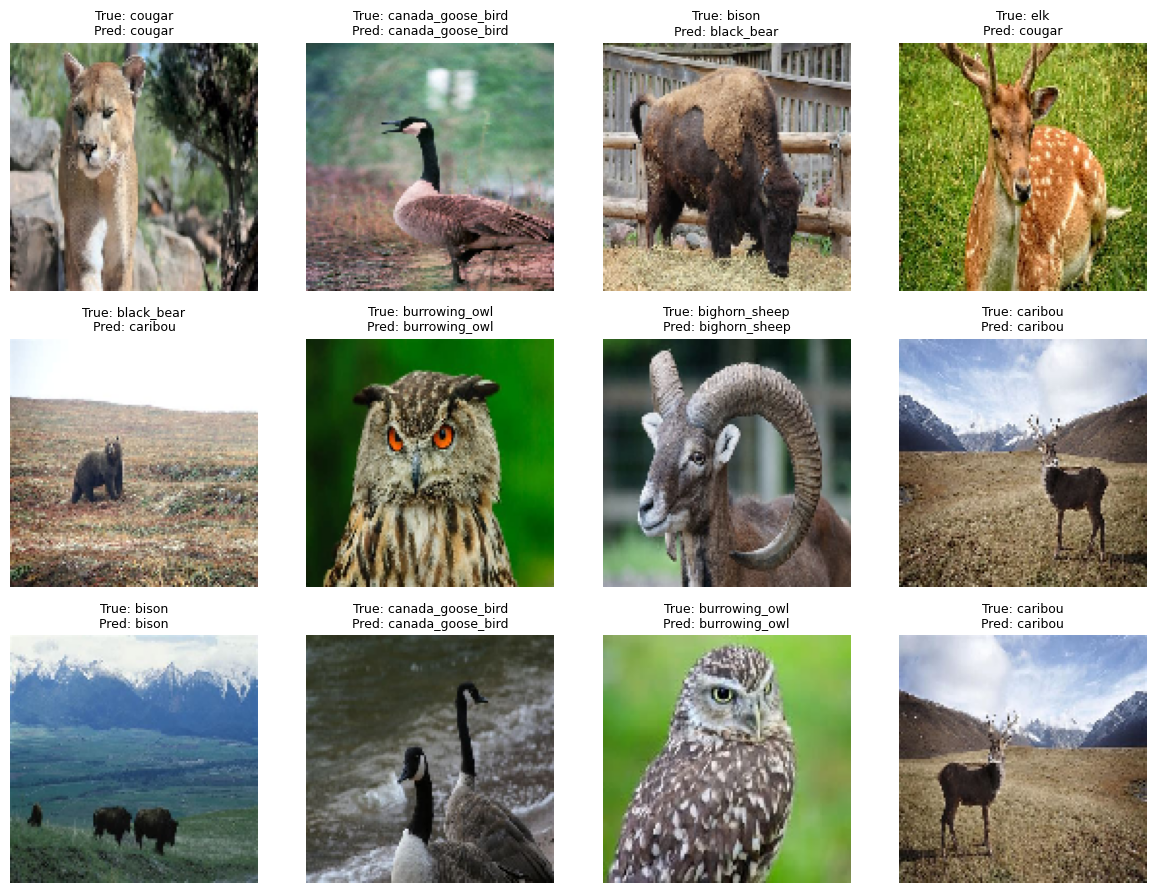

In [20]:
# =========================
# 10. VISUALIZE SOME RESULTS
# =========================
def plot_samples(images, true_labels, pred_labels=None, n=12):
    """
    Plots a grid of sample images with their true and optionally predicted labels.
    """
    plt.figure(figsize=(12, 12))
    for i in range(n):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        title_text = f"True: {labels[true_labels[i]]}"
        if pred_labels is not None:
            title_text += f"\nPred: {labels[pred_labels[i]]}"
        plt.title(title_text, fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show some test images with predictions
plot_samples(X_test, y_test, y_pred, n=12)


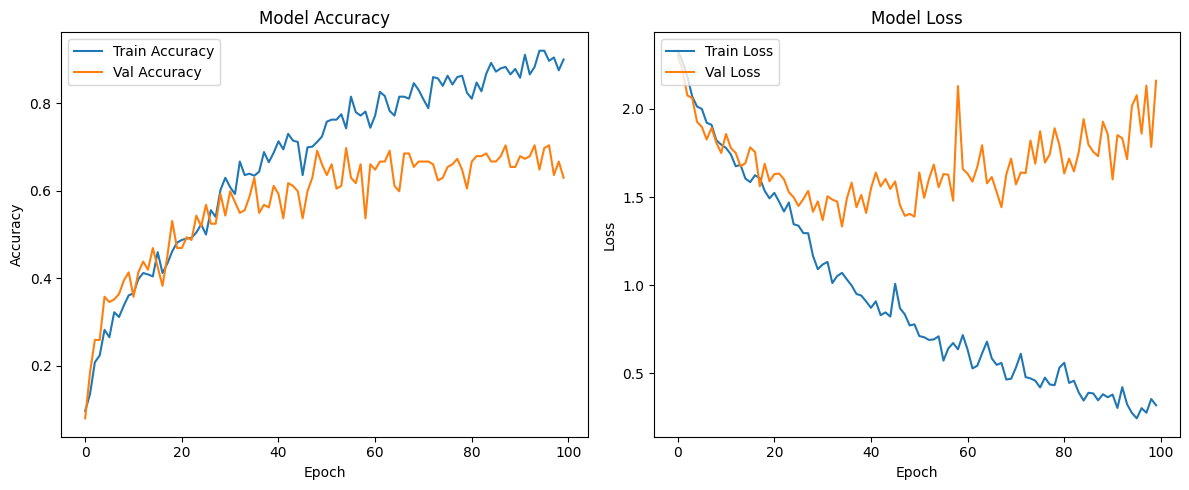

In [21]:
# =========================
# 10. TRAINING GRAPHS
# =========================
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [22]:
import cv2
import numpy as np
import tensorflow as tf

# Load and preprocess image
image_path = 'images_test/black_bear/39.jpg'
test_img = cv2.imread(image_path)  # Load image (BGR format)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert to RGB
test_img = cv2.resize(test_img, (128, 128))  # Resize to match model input

# Normalize the image (since model was trained with rescaling)
test_img = test_img / 255.0  # Rescale pixel values

# Expand dimensions to match the batch format expected by TensorFlow
test_img = np.expand_dims(test_img, axis=0)  # Shape becomes (1, 128, 128, 3)

# Make a prediction
bear_pred = model.predict(test_img)

# Get class with highest probability
predicted_class = np.argmax(bear_pred)  # Index of the highest probability class

# Map index to class name
class_names = ['bald_eagle', 'bighorn_sheep', 'bison', 'black_bear', 'burrowing_owl', 'canada_goose_bird', 'caribou', 
               'cougar', 'elk', 'golden_eagle', 'great_horned_owl', 'grizzly_bear', 'lynx', 'moose', 'mountain_goat', 
               'mule_deer', 'pine_marten', 'river_otter', 'snow_goose', 'white_tail_deer', 'wolf']

predicted_label = class_names[predicted_class]

# Print results
print("Predicted class:", predicted_label)
print("Prediction probabilities:", bear_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted class: black_bear
Prediction probabilities: [[6.5875829e-12 1.2866742e-13 2.0259081e-06 9.9999785e-01 2.8012873e-18
  6.4766382e-12 2.4445015e-10 2.2149732e-15 9.8974641e-14 1.4230660e-07]]


In [23]:
model.save("animal_classification_model.keras")  # Saves in SavedModel format

In [26]:
import base64
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
loaded_model = tf.keras.models.load_model("animal_classification_model.keras")

# Load and preprocess the image
image_path = 'images_test/bald_eagle/0.jpg'
test_img = cv2.imread(image_path)  # Load image (BGR format)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert to RGB
test_img = cv2.resize(test_img, (128, 128))  # Resize to match model input

# Normalize the image (since model was trained with rescaling)
test_img = test_img / 255.0  # Rescale pixel values

# Encode the image as base64
_, img_encoded = cv2.imencode('.jpg', test_img * 255)  # Convert back to uint8 format for base64
encoded_img = base64.b64encode(img_encoded)

# Decode the image from base64
img_decoded = base64.b64decode(encoded_img)

# Convert the decoded byte data back into an image
nparr = np.frombuffer(img_decoded, np.uint8)
decoded_img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
decoded_img = cv2.resize(decoded_img, (128, 128))
decoded_img = decoded_img / 255.0  # Rescale pixel values

# Expand dimensions to match the batch format expected by TensorFlow
decoded_img = np.expand_dims(decoded_img, axis=0)  # Shape becomes (1, 128, 128, 3)

# Show the image
pred_img = loaded_model.predict(decoded_img)

predicted_class = np.argmax(pred_img)  # Index of the highest probability class

# Map index to class name
class_names = ['bald_eagle', 'bighorn_sheep', 'bison', 'black_bear', 'burrowing_owl', 'canada_goose_bird', 'caribou', 
               'cougar', 'elk', 'golden_eagle', 'great_horned_owl', 'grizzly_bear', 'lynx', 'moose', 'mountain_goat', 
               'mule_deer', 'pine_marten', 'river_otter', 'snow_goose', 'white_tail_deer', 'wolf']

predicted_label = class_names[predicted_class]
print("Predicted class:", predicted_label)
print("Prediction probabilities:", pred_img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted class: bald_eagle
Prediction probabilities: [[9.9712116e-01 1.3414304e-11 2.5602351e-22 6.1010513e-15 3.1522981e-07
  2.8782645e-03 1.8933716e-17 1.1030625e-11 1.0477125e-30 1.6230616e-07]]
